In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/drive/MyDrive/DATASET/refined data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir = Path('/content/drive/MyDrive/DATASET/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
val_dir = Path('/content/drive/MyDrive/DATASET/refined data/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
import os
import pandas as pd

def image_processing(filepath, label_col):
    """
    Create a DataFrame with the filepath and the labels of the pictures.

    Args:
    - filepath: List of file paths.
    - label_col: Column name for labels.

    Returns:
    - DataFrame with 'Filepath' and 'Label' columns.
    """
    labels = [os.path.basename(os.path.dirname(f)) for f in filepath]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name=label_col)

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df

# Usage example:
train_df = image_processing(train_filepaths, label_col='Label')
test_df = image_processing(test_filepaths, label_col='Label')
val_df = image_processing(val_filepaths, label_col='Label')



In [ ]:


train_df = image_processing(train_filepaths, label_col='Label')
test_df = image_processing(test_filepaths, label_col='Label')
val_df = image_processing(val_filepaths, label_col='Label')

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 7472

Number of different labels: 36

Labels: ['sweetcorn' 'pear' 'potato' 'grapes' 'chilli pepper' 'cucumber' 'ginger'
 'garlic' 'sweetpotato' 'banana' 'capsicum' 'jalepeno' 'turnip'
 'watermelon' 'eggplant' 'lemon' 'paprika' 'lettuce' 'cauliflower' 'kiwi'
 'peas' 'mango' 'cabbage' 'onion' 'bell pepper' 'orange' 'beetroot' 'corn'
 'raddish' 'spinach' 'pomegranate' 'apple' 'soy beans' 'carrot'
 'pineapple' 'tomato']


In [ ]:
train_df.head(7)

,Filepath,Label
0,/content/drive/MyDrive/DATASET/refined data/tr...,sweetcorn
1,/content/drive/MyDrive/DATASET/refined data/tr...,pear
2,/content/drive/MyDrive/DATASET/refined data/tr...,potato
3,/content/drive/MyDrive/DATASET/refined data/tr...,potato
4,/content/drive/MyDrive/DATASET/refined data/tr...,grapes
5,/content/drive/MyDrive/DATASET/refined data/tr...,chilli pepper
6,/content/drive/MyDrive/DATASET/refined data/tr...,chilli pepper


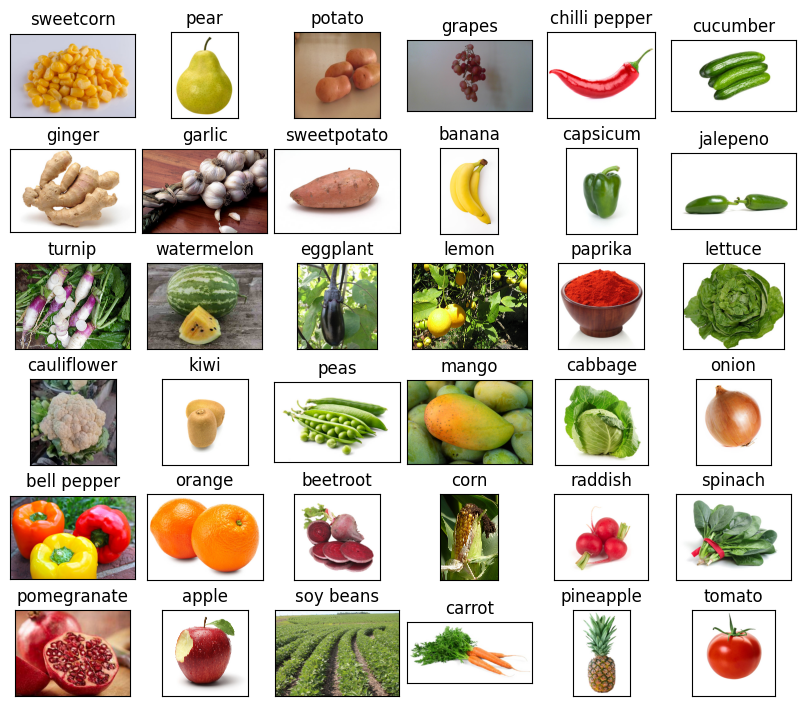

In [ ]:
import matplotlib.pyplot as plt

def display_unique_images(df, num_rows=6, num_cols=6):
    """
    Display images from unique categories in the DataFrame.

    Args:
    - df: DataFrame containing 'Filepath' and 'Label' columns.
    - num_rows: Number of rows for the subplot grid.
    - num_cols: Number of columns for the subplot grid.
    """
    unique_labels = df['Label'].unique()
    num_unique_labels = len(unique_labels)
    num_plots = num_rows * num_cols

    if num_unique_labels < num_plots:
        num_plots = num_unique_labels

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 7),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            label = unique_labels[i]
            filepath = df[df['Label'] == label]['Filepath'].iloc[0]
            ax.imshow(plt.imread(filepath))
            ax.set_title(label, fontsize=12)
        else:
            ax.axis('off')  # Turn off empty subplots

    plt.tight_layout(pad=0.5)
    plt.show()

# Usage example:
display_unique_images(train_df)


In [ ]:
import tensorflow as tf

# Define the preprocessing function to normalize pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Set up the training data generator with data augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Set up the validation and test data generators without data augmentation
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the preprocessing function to normalize pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create an ImageDataGenerator instance for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.4,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generate batches of augmented training data from DataFrame
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=0
)


Found 7472 validated image filenames belonging to 36 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the preprocessing function to normalize pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create an ImageDataGenerator instance for validation data
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generate batches of validation data from DataFrame
val_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False  # No need to shuffle validation data
)


Found 1782 validated image filenames belonging to 36 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the preprocessing function to normalize pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create an ImageDataGenerator instance for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generate batches of test data from DataFrame
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 1782 validated image filenames belonging to 36 classes.


In [ ]:
import tensorflow as tf

# Load the MobileNetV2 model with imagenet weights, excluding the top classification layers
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the weights of the pretrained layers
pretrained_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# Load MobileNetV2 model with pre-trained weights (excluding top classification layers)
pretrained_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers of the pretrained model
pretrained_model.trainable = False

# Define the classification head
inputs = pretrained_model.input
x = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
outputs = Dense(36, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Visualize and save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=64,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
117/117 [==============================] - 387s 3s/step - loss: 2.7954 - accuracy: 0.2531 - val_loss: 1.1238 - val_accuracy: 0.7710
Epoch 2/10
117/117 [==============================] - 360s 3s/step - loss: 1.5520 - accuracy: 0.5558 - val_loss: 0.5633 - val_accuracy: 0.8788
Epoch 3/10
117/117 [==============================] - 373s 3s/step - loss: 1.1759 - accuracy: 0.6530 - val_loss: 0.4621 - val_accuracy: 0.8928
Epoch 4/10
117/117 [==============================] - 385s 3s/step - loss: 1.0171 - accuracy: 0.6957 - val_loss: 0.3729 - val_accuracy: 0.9186
Epoch 5/10
117/117 [==============================] - 370s 3s/step - loss: 0.9206 - accuracy: 0.7250 - val_loss: 0.3430 - val_accuracy: 0.9130
Epoch 6/10
117/117 [==============================] - 366s 3s/step - loss: 0.8261 - accuracy: 0.7535 - val_loss: 0.3251 - val_accuracy: 0.9192
Epoch 7/10
117/117 [==============================] - 377s 3s/step - loss: 0.7811 - accuracy: 0.7627 - val_loss: 0.3199 - val_accuracy: 0.9226

28/28 [==============================] - 58s 2s/step
Accuracy: 0.9338
Precision: 0.9412
Recall: 0.9337
F1 Score: 0.9305
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        48
           1       0.94      1.00      0.97        50
           2       0.97      0.78      0.87        50
           3       0.86      1.00      0.93        50
           4       0.94      1.00      0.97        50
           5       0.96      1.00      0.98        50
           6       0.98      0.98      0.98        49
           7       1.00      1.00      1.00        49
           8       0.94      0.94      0.94        47
           9       0.83      1.00      0.91        50
          10       0.98      1.00      0.99        50
          11       0.72      0.98      0.83        50
          12       0.98      1.00      0.99        50
          13       1.00      1.00      1.00        50
          14       1.00      0.98      0.99   

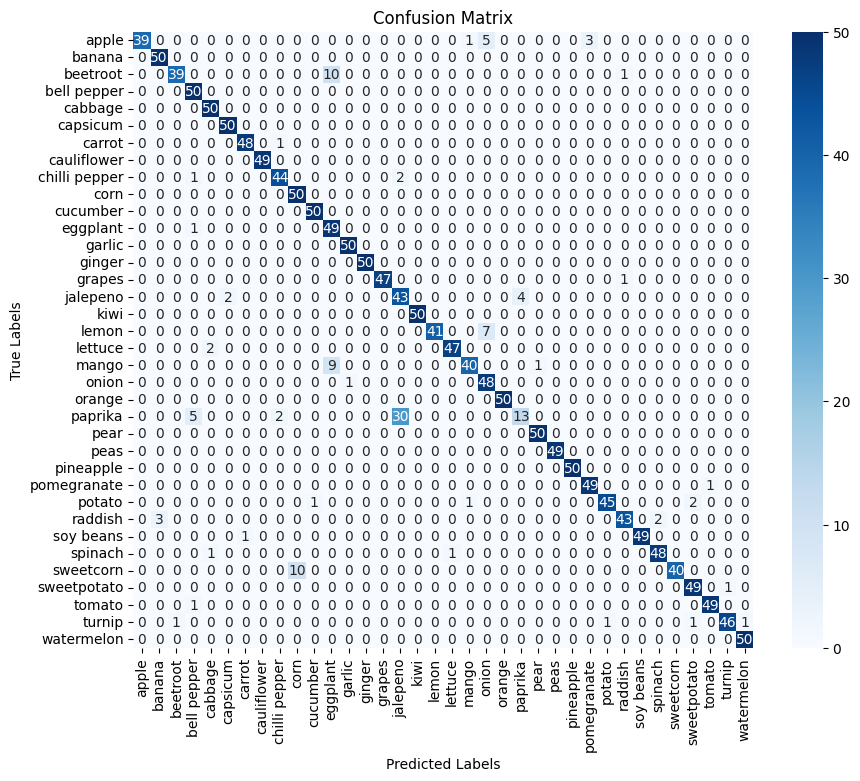

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities from the model
pred_probs = model.predict(test_images)
pred = np.argmax(pred_probs, axis=1)

# Get true labels from test dataset
true_labels = test_images.classes

# Convert class indices to class labels
class_labels = list(test_images.class_indices.keys())

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, pred, average='macro')
recall = recall_score(true_labels, pred, average='macro')
f1 = f1_score(true_labels, pred, average='macro')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Predict the label of the test_images
pred_probs = model.predict(test_images)
pred = np.argmax(pred_probs, axis=1)

# Map the label indices to class labels
class_labels = {v: k for k, v in train_images.class_indices.items()}

# Convert predicted indices to class labels
pred_labels = [class_labels[idx] for idx in pred]

# Ensure that the predicted labels match the expected format
if len(pred_labels) != len(test_images.filenames):
    print("Error: Number of predictions does not match the number of test images.")
    # Handle the error appropriately, such as returning or logging an error message
else:
    print("Predictions successfully generated.")

# Print the first few predicted labels for verification
print("Sample predicted labels:", pred_labels[:5])


28/28 [==============================] - 78s 3s/step
Predictions successfully generated.
Sample predicted labels: ['pomegranate', 'beetroot', 'bell pepper', 'turnip', 'cauliflower']


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def output(location, model, labels):
    try:
        # Load and preprocess the image
        img = load_img(location, target_size=(224, 224, 3))
        img = img_to_array(img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make predictions using the provided model
        prediction = model.predict(img)

        # Get the class index with the highest probability
        predicted_class_index = np.argmax(prediction)

        # Map the class index to the corresponding label
        predicted_label = labels[predicted_class_index]

        return predicted_label

    except Exception as e:
        # Handle any exceptions gracefully
        print(f"An error occurred: {e}")
        return None


In [ ]:
from keras.models import load_model

# Load the model

model.save('FV.h5')
# Load the labels
# Assuming labels is a dictionary mapping class indices to class labels
labels = {0: 'apple', 1: 'banana', 2: 'watermelon'}  # Update with your label mapping

def output(location, model, labels):
    try:
        from keras.preprocessing.image import load_img, img_to_array
        import numpy as np

        # Load and preprocess the image
        img = load_img(location, target_size=(224, 224, 3))
        img = img_to_array(img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make predictions using the provided model
        prediction = model.predict(img)

        # Get the class index with the highest probability
        predicted_class_index = np.argmax(prediction)

        # Map the class index to the corresponding label
        predicted_label = labels.get(predicted_class_index)

        return predicted_label if predicted_label else "Unknown"

    except Exception as e:
        # Handle any exceptions gracefully
        print(f"An error occurred: {e}")
        return None

# Use the output function
img = output('/content/drive/MyDrive/DATASET/train/watermelon/Watermelon119.jpg', model, labels)
print("Predicted label:", img)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 700ms/step
Predicted label: Unknown


In [ ]:
model.save('FV.h5')

Training Accuracy: 0.796440064907074
Validation Accuracy: 0.9337822794914246
Training Loss: 0.6742081046104431
Validation Loss: 0.2748035192489624


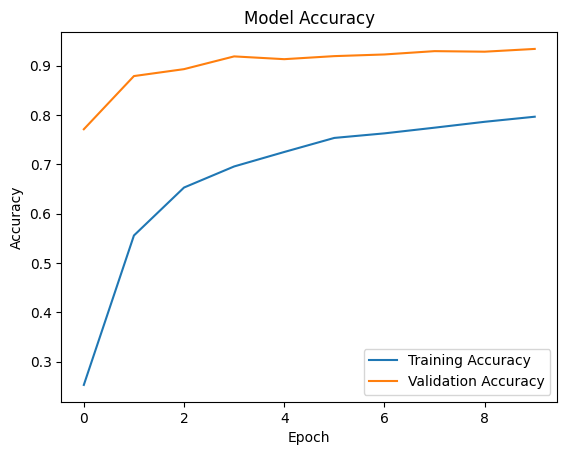

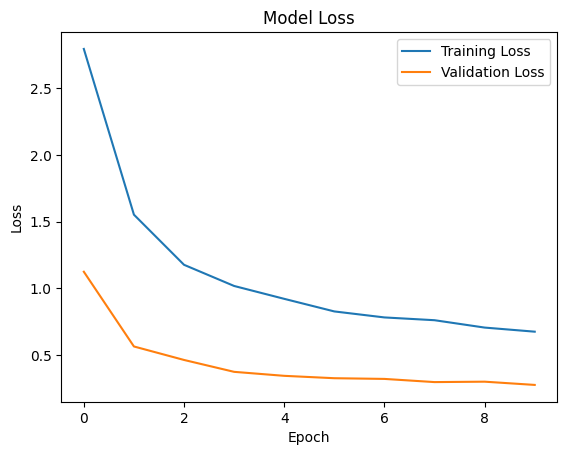

In [ ]:
import matplotlib.pyplot as plt

# Ensure that history object is defined or passed to the code snippet
try:
    # Print final training and validation accuracy
    print('Training Accuracy:', history.history['accuracy'][-1])
    print('Validation Accuracy:', history.history['val_accuracy'][-1])

    # Print final training and validation loss
    print('Training Loss:', history.history['loss'][-1])
    print('Validation Loss:', history.history['val_loss'][-1])

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

except Exception as e:
    # Handle cases where history object is not available
    print(f"An error occurred: {e}")


28/28 [==============================] - 55s 2s/step


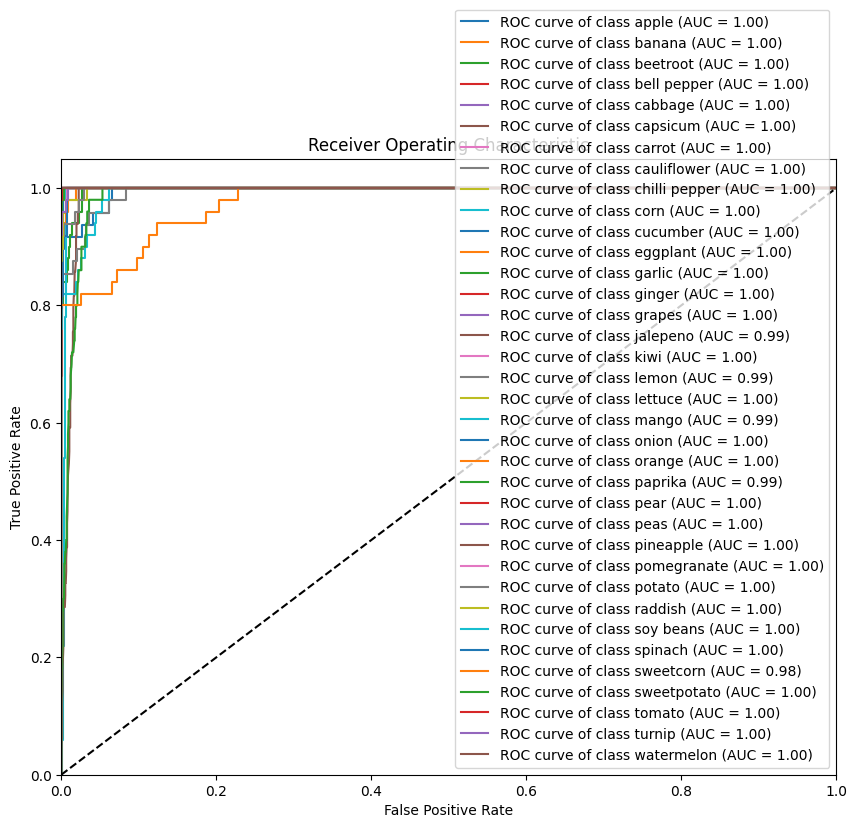

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
from sklearn.metrics import roc_curve


# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

from sklearn.preprocessing import LabelEncoder

# Convert class labels to numerical format (assuming you have a DataFrame 'test_df' with a 'Label' column)
label_encoder = LabelEncoder()
test_df['Label'] = label_encoder.fit_transform(test_df['Label'])

# Prepare test_labels
test_labels = tf.keras.utils.to_categorical(test_df['Label'], num_classes=36)

# Calculate ROC curve
fpr = dict()
tpr = dict()
roc_auc_curve = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], pred_probs[:, i])
    roc_auc_curve[i] = roc_auc_score(test_labels[:, i], pred_probs[:, i])

# Plot ROC curves
#plt.figure(figsize=(10, 8))
#for i in range(len(labels)):
 #   plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:.2f})'.format(labels[i], roc_auc_curve[i]))

#plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
#plt.legend(loc="lower right")
#plt.show()


# Plot ROC curves with ROC AUC values
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:.2f})'.format(labels[i], roc_auc_curve[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




28/28 [==============================] - 102s 4s/step


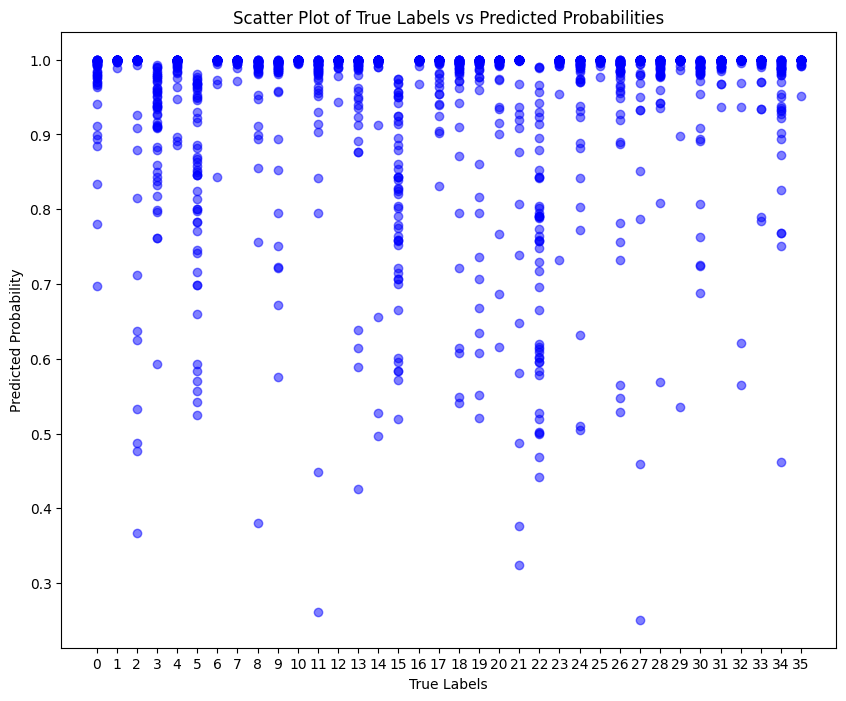

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the label probabilities using your model
pred_probs = model.predict(test_images)

# Get the predicted labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true labels
true_labels = np.argmax(test_labels, axis=1)  # Assuming test_labels is one-hot encoded

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(true_labels, pred_probs.max(axis=1), c='blue', alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Probability')
plt.title('Scatter Plot of True Labels vs Predicted Probabilities')
plt.xticks(range(36))  # Adjust this if needed
plt.show()


28/28 [==============================] - 89s 3s/step
There is a positive correlation between predicted probabilities and true labels.


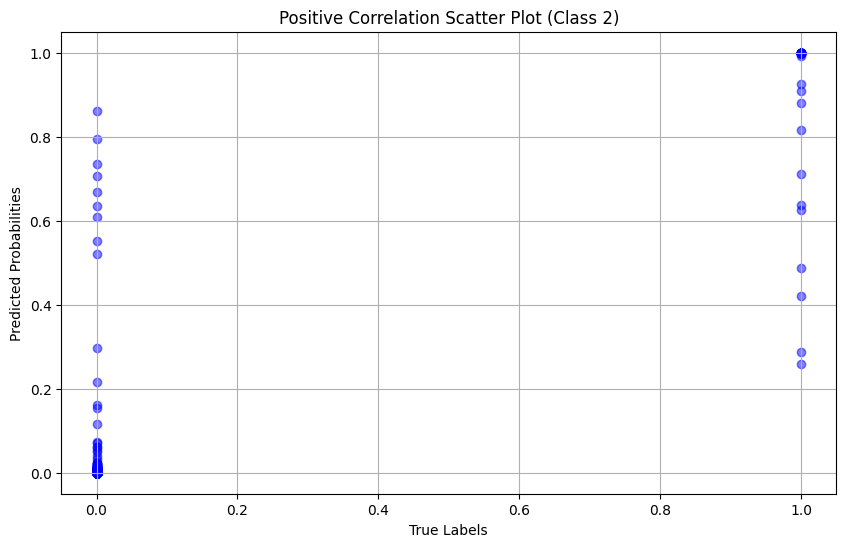

Pearson Correlation: 0.9320
P-value: 0.0000


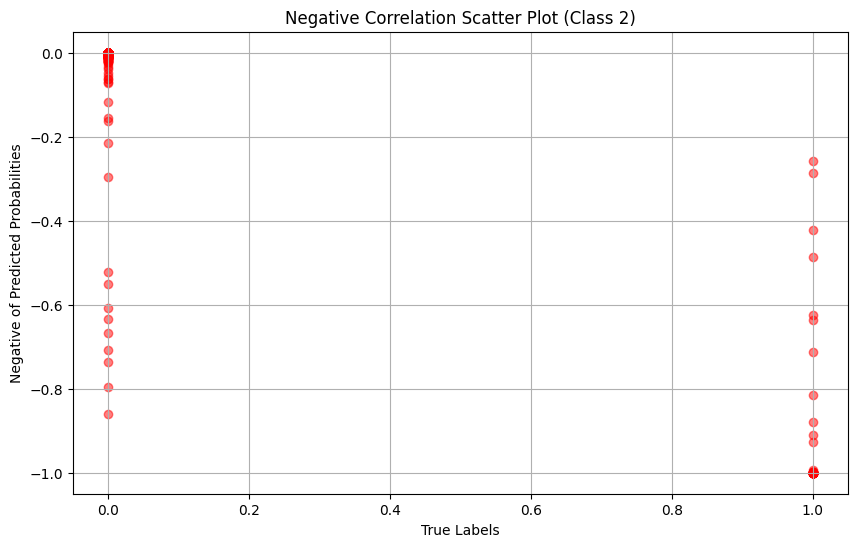

Pearson Correlation: -0.9320
P-value: 0.0000


In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Predict the label probabilities using your model
pred_probs = model.predict(test_images)

# Get the predicted probabilities for the positive class (adjust class index as needed)
positive_probs = pred_probs[:, 2]

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(-positive_probs, true_labels)

# Print the correlation coefficient and p-value
#print(f"Positive Correlation: {correlation:.4f}")
#print(f"P-value: {p_value:.4f}")

# Interpret the correlation
if correlation > 0:
    print("There is a positive correlation between predicted probabilities and true labels.")
elif correlation < 0:
    print("There is a negative correlation between predicted probabilities and true labels.")
else:
    print("There is no linear correlation between predicted probabilities and true labels.")


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate the predicted probabilities for the positive class (replace 'positive_class_index' with the correct index)
positive_class_index = 2  # Replace with the correct class index
positive_probs = pred_probs[:, positive_class_index]

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = stats.pearsonr(positive_probs, test_labels[:, positive_class_index])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(test_labels[:, positive_class_index], positive_probs, color='blue', alpha=0.5)
plt.title(f'Positive Correlation Scatter Plot (Class {positive_class_index})')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.grid(True)
plt.show()

print(f"Pearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


# Calculate the negative of the predicted probabilities for the positive class
negative_probs = -positive_probs

# Calculate Pearson correlation coefficient and p-value for the negative of predicted probabilities
correlation, p_value = stats.pearsonr(negative_probs, test_labels[:, positive_class_index])

# Create scatter plot for negative correlation
plt.figure(figsize=(10, 6))
plt.scatter(test_labels[:, positive_class_index], negative_probs, color='red', alpha=0.5)
plt.title(f'Negative Correlation Scatter Plot (Class {positive_class_index})')
plt.xlabel('True Labels')
plt.ylabel('Negative of Predicted Probabilities')
plt.grid(True)
plt.show()

print(f"Pearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")



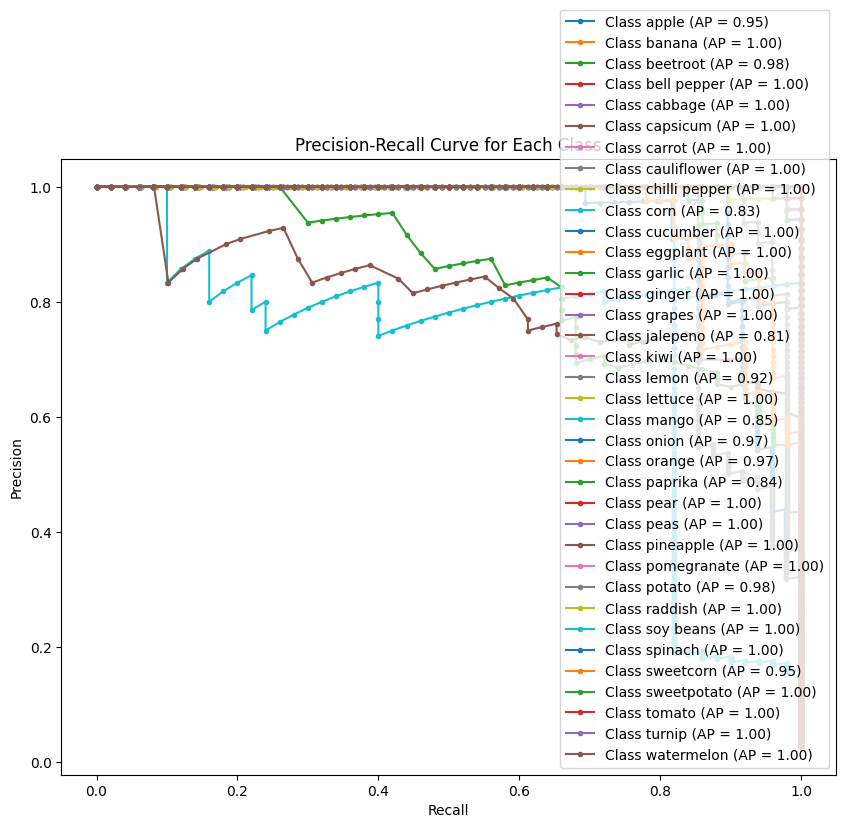

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], pred_probs[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], pred_probs[:, i])

# Plot precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i], marker='.', label='Class {0} (AP = {1:.2f})'.format(labels[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(test_labels.argmax(axis=1), pred)

# Print the result
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.9319
